In [4]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col,mean
from pyspark.sql.types import (
    StructType, StructField, IntegerType, LongType,
    StringType, FloatType, TimestampType
)
import matplotlib.pyplot as plt


# Create Spark session
spark = SparkSession.builder \
    .appName("JapanTradeStats") \
    .master("local[*]") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "10g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")


25/12/19 21:34:04 WARN Utils: Your hostname, eng-mohammed-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/12/19 21:34:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/19 21:34:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("category_id", StringType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("user_id", LongType(), True),
    StructField("user_session", StringType(), True)
])

# Load CSV with schema
df = spark.read.csv(
    "file:///home/eng-mohammed/Desktop/Data.csv",
    header=True,
    schema=schema
)
data =df
data.cache()
data.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: string (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_session: string (nullable = true)



In [6]:
#---------------------------------------------------------------part2--------------------------------------
# understant data
print("Total data is : ",data.count())
print("describe data : ",data.describe())
# data.show(5)



Total data is :  21224382
describe data :  DataFrame[summary: string, event_type: string, product_id: string, category_id: string, category_code: string, brand: string, price: string, user_id: string, user_session: string]


In [7]:
null_counts = data.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in data.columns
])
null_counts.show()

+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|      6931121|3001615|    0|      0|           1|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+



In [8]:
from pyspark.sql.functions import col, when, mean 
df = data.withColumn("product_id", when(col("product_id")=="NULL",None).otherwise(col("product_id"))) \
         .withColumn("brand", when(col("brand")=="NULL",None).otherwise(col("brand"))) \
         .withColumn("price", when(col("price")=="NULL",None).otherwise(col("price")))\
         .withColumn("category_code",when(col("category_code")=="NULL",None).otherwise(col("category_code")))

# Drop duplicates
df = df.dropDuplicates()

# Filter invalid product_id
df = df.filter(col("product_id").isNotNull())

# Fill missing prices with mean
mean_price = df.select(mean("price")).collect()[0][0]

df_clean = df.withColumn(
    "price",
    when(col("price").isNull(), mean_price).otherwise(col("price"))
)

df_clean.show(10)

+-------------------+----------+----------+-------------------+--------------------+---------+------------------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|    brand|             price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+---------+------------------+---------+--------------------+
|2019-10-01 02:00:19|      view|   1005135|2053013555631882655|electronics.smart...|    apple|   1747.7900390625|535871217|c6bd7419-2748-4c5...|
|2019-10-01 02:00:22|      view|   1480714|2053013561092866779|   computers.desktop|   pulser|  921.489990234375|512742880|0d0d91c2-c9c2-4e8...|
|2019-10-01 02:00:37|      view|   1701111|2053013553031414015|computers.periphe...|     acer| 514.7899780273438|547028884|3ea7c620-a8d7-45c...|
|2019-10-01 02:00:42|      view|   4803399|2053013554658804075|electronics.audio...|      jbl|33.209999084472656|555428858|8a6afed

In [9]:
df_fe = (df_clean
    .withColumn("event_date", F.to_date("event_time"))
    .withColumn("event_month",F.month("event_time"))
    .withColumn("event_hour", F.hour("event_time"))
    .withColumn("category_main",
                F.when(F.col("category_code").isNotNull(),
                       F.split("category_code", "\\.")[0])
                .otherwise(None))
)
df_fe.show(5)

+-------------------+----------+----------+-------------------+--------------------+------+------------------+---------+--------------------+----------+-----------+----------+-------------+
|         event_time|event_type|product_id|        category_id|       category_code| brand|             price|  user_id|        user_session|event_date|event_month|event_hour|category_main|
+-------------------+----------+----------+-------------------+--------------------+------+------------------+---------+--------------------+----------+-----------+----------+-------------+
|2019-10-01 02:00:19|      view|   1005135|2053013555631882655|electronics.smart...| apple|   1747.7900390625|535871217|c6bd7419-2748-4c5...|2019-10-01|         10|         2|  electronics|
|2019-10-01 02:00:22|      view|   1480714|2053013561092866779|   computers.desktop|pulser|  921.489990234375|512742880|0d0d91c2-c9c2-4e8...|2019-10-01|         10|         2|    computers|
|2019-10-01 02:00:37|      view|   1701111|2053013

In [10]:
events_dist = df_fe.groupBy("event_type").count()
events_dist.show()

+----------+--------+
|event_type|   count|
+----------+--------+
|  purchase|  374896|
|      cart|  414214|
|      view|20421652|
+----------+--------+



In [11]:
top_viewed_products = (df_fe
    .filter(F.col("event_type") == "view")
    .groupBy(["product_id","category_main"])
    .count()
    .orderBy(F.desc("count"))
)

top_viewed_products.show(10)


+----------+-------------+------+
|product_id|category_main| count|
+----------+-------------+------+
|   1004856|  electronics|210131|
|   1004767|  electronics|177733|
|   1005115|  electronics|177529|
|   1004249|  electronics|104858|
|   1005105|  electronics|101739|
|   1004870|  electronics| 96269|
|   1004833|  electronics| 95613|
|   4804056|  electronics| 89122|
|   1002544|  electronics| 89045|
|   5100816|         NULL| 86773|
+----------+-------------+------+
only showing top 10 rows



In [29]:
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F
from pyspark.sql.functions import format_number

# 1️⃣ Clean & cast price to double
df_fe = df_fe.withColumn(
    "price",
    F.regexp_replace("price", ",", "")  # remove commas if any
     .cast(DoubleType())
)

# 2️⃣ Optional: remove duplicates based on user_session + product_id + event_time
df_fe = df_fe.dropDuplicates(["user_session", "product_id", "event_time"])

# 3️⃣ Filter for valid purchases
df_purchase = df_fe.filter(
    (F.col("event_type") == "purchase") &
    (F.col("brand").isNotNull()) &
    (F.col("price").isNotNull()) &
    (F.col("price") > 0)
)

# 4️⃣ Aggregate revenue by brand
brand_revenue = (
    df_purchase
    .groupBy("brand")
    .agg(F.round(F.sum("price"), 2).alias("total_revenue"))
    .orderBy(F.desc("total_revenue"))
    .withColumn("formatted_revenue", format_number("total_revenue", 2))  # Format with 2 decimal places
)

# 5️⃣ Show top 10 brands by revenue
brand_revenue.show(truncate=False)

# # 6️⃣ Check schema (optional)
# brand_revenue.printSchema()

# brand_revenue['brand'].count()


+--------+-------------+-----------------+
|brand   |total_revenue|formatted_revenue|
+--------+-------------+-----------------+
|apple   |5.547824184E7|55,478,241.84    |
|samsung |2.314442981E7|23,144,429.81    |
|xiaomi  |4569052.21   |4,569,052.21     |
|huawei  |2564497.31   |2,564,497.31     |
|acer    |1777231.89   |1,777,231.89     |
|lg      |1671315.13   |1,671,315.13     |
|lucente |1647740.05   |1,647,740.05     |
|sony    |1171797.32   |1,171,797.32     |
|oppo    |1065669.05   |1,065,669.05     |
|lenovo  |996678.2     |996,678.20       |
|hp      |729524.25    |729,524.25       |
|indesit |626278.94    |626,278.94       |
|bosch   |598309.42    |598,309.42       |
|artel   |488020.93    |488,020.93       |
|beko    |467805.92    |467,805.92       |
|asus    |428719.69    |428,719.69       |
|haier   |368911.47    |368,911.47       |
|dauscher|312652.57    |312,652.57       |
|canon   |285966.78    |285,966.78       |
|vivo    |279113.0     |279,113.00       |
+--------+-

In [ ]:
import matplotlib.pyplot as plt

# Convert Spark DF to Pandas
pdf_brand_revenue = brand_revenue.toPandas()

# Clean the 'formatted_revenue' column: remove commas and convert to float
pdf_brand_revenue['formatted_revenue'] = pdf_brand_revenue['formatted_revenue'].replace({',': ''}, regex=True).astype(float)

# Define the number of brands per chart
brands_per_chart = 20
num_charts = (len(pdf_brand_revenue) // brands_per_chart) + 1  # Calculate the number of charts needed

# Create subplots for each chart
fig, axes = plt.subplots((num_charts + 1) // 2, 2, figsize=(70, 50))  # Dynamic layout based on the number of charts
axes = axes.flatten()

# Loop over the segments (every 50 brands) and plot each pie chart
for i in range(num_charts):
    # Define the subset of data for this pie chart (50 brands per chart)
    start_idx = i * brands_per_chart
    end_idx = (i + 1) * brands_per_chart if i != num_charts - 1 else len(pdf_brand_revenue)  # Last chart gets the remaining brands
    subset = pdf_brand_revenue.iloc[start_idx:end_idx]

    # Plot the pie chart for this subset
    axes[i].pie(subset['formatted_revenue'], labels=subset['brand'], autopct='%1.1f%%', startangle=90, explode=[0.1]*len(subset))
    axes[i].set_title(f"Brand Revenue Segment {i + 1}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [13]:

hourly_traffic = (
    df_fe
    .groupBy("event_hour")   # only by hour
    .count()                 # count all events in that hour
    .orderBy("event_hour")   # order by hour
)

hourly_traffic.show(24)


+----------+-------+
|event_hour|  count|
+----------+-------+
|         0| 126896|
|         1| 103456|
|         2| 153254|
|         3| 293837|
|         4| 548050|
|         5| 803214|
|         6| 994029|
|         7|1107687|
|         8|1170709|
|         9|1219196|
|        10|1257552|
|        11|1258358|
|        12|1212907|
|        13|1150017|
|        14|1034604|
|        15|1121199|
|        16|1276760|
|        17|1430905|
|        18|1474938|
|        19|1309921|
|        20| 983984|
|        21| 623273|
|        22| 349228|
|        23| 204794|
+----------+-------+



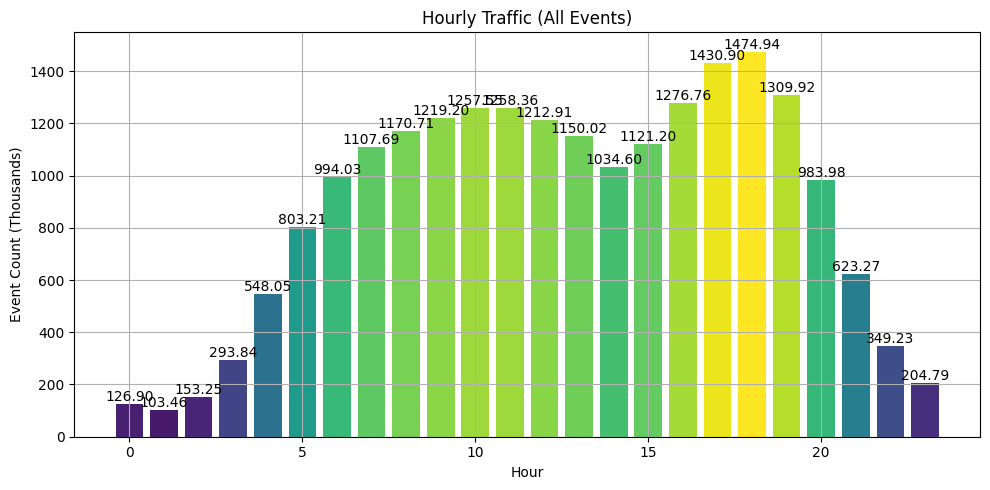

In [39]:

# ======================= HOURLY TRAFFIC =============================

# Convert the Spark DataFrame to a Pandas DataFrame
pdf_hourly_traffic = hourly_traffic.toPandas()

# Create the bar chart
plt.figure(figsize=(10, 5))

# Divide the event counts by 1000
pdf_hourly_traffic['count_thousands'] = pdf_hourly_traffic['count'] / 1000

# Generate the bar chart with custom colors
bars = plt.bar(pdf_hourly_traffic['event_hour'], pdf_hourly_traffic['count_thousands'], color=plt.cm.viridis(pdf_hourly_traffic['count'] / max(pdf_hourly_traffic['count'])))

# Add titles and labels
plt.title("Hourly Traffic (All Events)")
plt.xlabel("Hour")
plt.ylabel("Event Count (Thousands)")

# Add text labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# Add grid for better visibility
plt.grid(True)

# Adjust the layout to prevent overlapping labels
plt.tight_layout()

# Show the plot
plt.show()


In [14]:
hourly_revenue = (
    df_fe
    .filter(F.col("event_type") == "purchase")
    .groupBy("event_hour")
    .agg(
        F.count("*").alias("num_purchases"),
        F.round(F.sum("price"),2).alias("total_revenue")
    )
    .orderBy("event_hour")
)

hourly_revenue.show(24)


+----------+-------------+-------------+
|event_hour|num_purchases|total_revenue|
+----------+-------------+-------------+
|         0|         1835|    682548.96|
|         1|         1324|    459196.42|
|         2|         1552|    528516.77|
|         3|         3076|    879922.07|
|         4|         7475|   2060113.52|
|         5|        15506|   4590832.74|
|         6|        21403|   6240510.49|
|         7|        24841|   7422935.91|
|         8|        26641|    8117309.0|
|         9|        27831|   8442127.55|
|        10|        29060|   8961172.57|
|        11|        29940|   9515490.01|
|        12|        27269|   8557114.12|
|        13|        24504|   7656811.81|
|        14|        20103|   6351063.06|
|        15|        18641|   5876990.72|
|        16|        17197|   5217365.54|
|        17|        17800|    5162455.9|
|        18|        17050|    4970594.5|
|        19|        14785|   4490289.53|
|        20|        11553|   3775131.19|
|        21|    

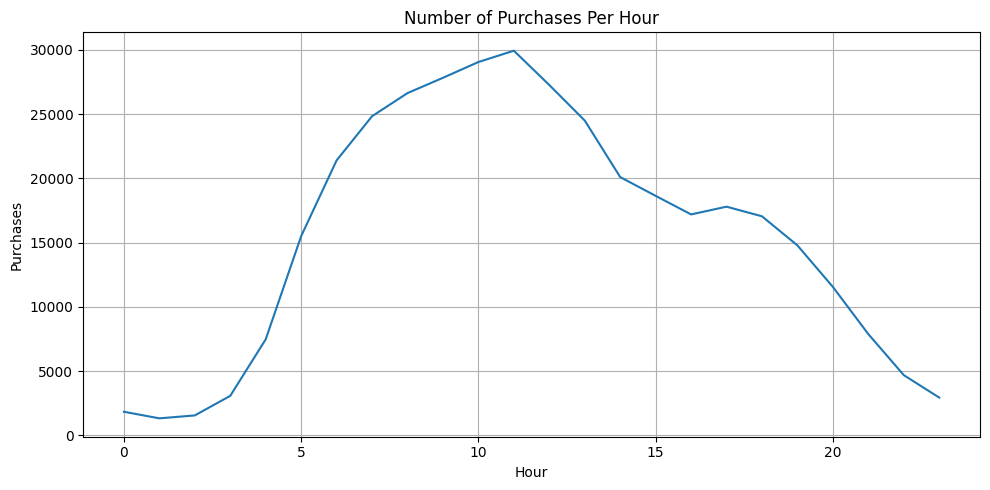

In [40]:
# ======================= HOURLY PURCHASE COUNT ======================

pdf_hourly_revenue = hourly_revenue.toPandas()

plt.figure(figsize=(10,5))
plt.plot(pdf_hourly_revenue['event_hour'], pdf_hourly_revenue['num_purchases'])
plt.title("Number of Purchases Per Hour")
plt.xlabel("Hour")
plt.ylabel("Purchases")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

# ======================= TOP VIEWED PRODUCTS ========================

top10_viewed = top_viewed_products.limit(10)
pdf_top_viewed = top10_viewed.toPandas()

plt.figure(figsize=(10,5))
plt.bar(pdf_top_viewed['product_id'], pdf_top_viewed['count'])
plt.title("Top Viewed Products")
plt.xlabel("Product ID")
plt.ylabel("Views Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
